In [1]:
from utils import prepare_jupyter
prepare_jupyter()

In [2]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

from data import Dataset

/Users/tomek/.virtualenvs/masters/lib/python3.6/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
aids = fetch_openml('aids')

In [4]:
target = aids['target']

le = LabelEncoder()
le.fit(target)
le.transform(target)
le.classes_

array(['Female', 'Male'], dtype=object)

## Manually concatenate

In [5]:
def prepare_data(dataset):
    X = dataset.data
    y = dataset.target
    
    categories = list(dataset.categories.keys())
    feature_names = dataset.feature_names
    
    all_idx = set(range(0, X.shape[1]))
    cat_features_idx = [feature_names.index(cat) for cat in categories]
    num_features_idx = list(all_idx.difference(cat_features_idx))
    X_cat = X[:, cat_features_idx]
    X_num = X[:, num_features_idx]
    
    ohe = OneHotEncoder(categories='auto', sparse=False)
    X_cat_transformed = ohe.fit_transform(X_cat)
    
    print(X_cat_transformed.shape, X_num.shape)
    
    return np.concatenate((X_cat_transformed, X_num), axis=1)
    

In [6]:
prepare_data(aids)[0, 0:5],prepare_data(aids)[0, 5:10], prepare_data(aids)[0, 10:]

(50, 10) (50, 2)
(50, 10) (50, 2)
(50, 10) (50, 2)


(array([1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1.]),
 array([2.5550000e+03, 1.4443382e+07]))

## ColumnTransformer

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py

In [7]:
# Using ColumnTransformer
def prepare_data(dataset):
    X = dataset.data
    y = dataset.target
    
    categories = list(dataset.categories.keys())
    feature_names = dataset.feature_names
    
    all_idx = set(range(0, X.shape[1]))
    cat_features_idx = [feature_names.index(cat) for cat in categories]
    num_features_idx = list(all_idx.difference(cat_features_idx))
    
    ct = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(categories='auto', sparse=False), cat_features_idx),
        ('num', 'passthrough', num_features_idx)
    ])
    
    return ct.fit_transform(X)


In [8]:
# prepare_data(aids)

## My Dataset


In [9]:
train_data, val_data = Dataset.from_openml('aids').split(0.2)

In [10]:
from structure import AdaboostEnsemble

params = {
    'n_estimators': 10,
    'max_depth': 5
}
ada = AdaboostEnsemble(params)
ada.fit(train_data)
# ada.predict(val_data.X)

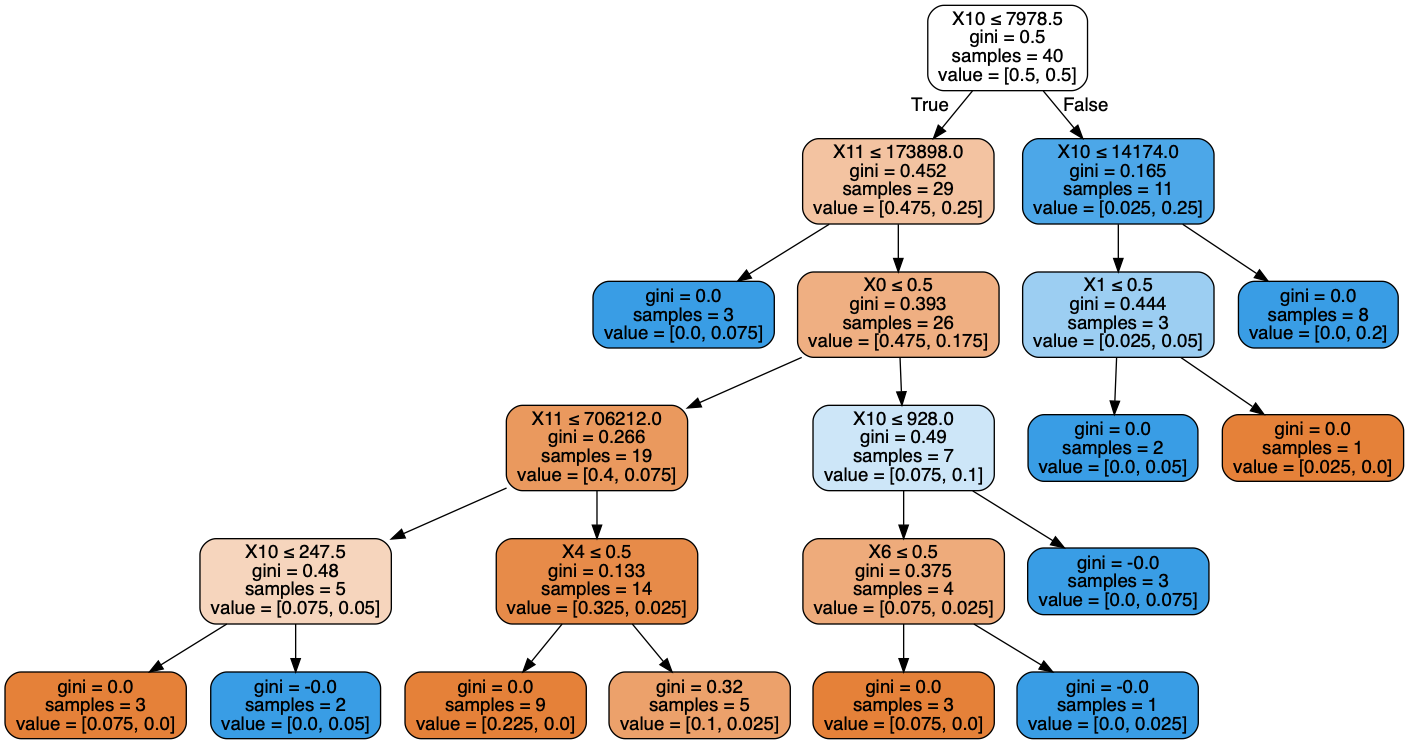

In [11]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dtree = ada.clf.estimators_[0]
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [12]:
any_tree = ada.trees[0]
any_tree.draw('here.png', verbose=True)
# print(dot_data.getvalue())

Split = AIDS
<=
7978.5
Split = Total
<=
173898.0
Leaf = Male
1
Split = Age_0
<=
0.5
Split = Total
<=
706212.0
Split = AIDS
<=
247.5
Leaf = Female
0
Leaf = Male
1
Split = Age_4
<=
0.5
Leaf = Female
0
Leaf = Female
0
Split = AIDS
<=
928.0
Split = Race_1
<=
0.5
Leaf = Female
0
Leaf = Male
1
Leaf = Male
1
Split = AIDS
<=
14174.0
Split = Age_1
<=
0.5
Leaf = Male
1
Leaf = Female
0
Leaf = Male
1


In [13]:
any_tree.predict(val_data.X)

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0])

In [14]:
ada.clf.estimators_[0].predict(val_data.X)

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0])